### Quick intro: Vision Transformer (ViT) by Google Brain

The Vision Transformer (ViT) is basically BERT, but applied to images. It attains excellent results compared to state-of-the-art convolutional networks. In order to provide images to the model, each image is split into a sequence of fixed-size patches (typically of resolution 16x16 or 32x32), which are linearly embedded. One also adds a [CLS] token at the beginning of the sequence in order to classify images. Next, one adds absolute position embeddings and provides this sequence to the Transformer encoder.

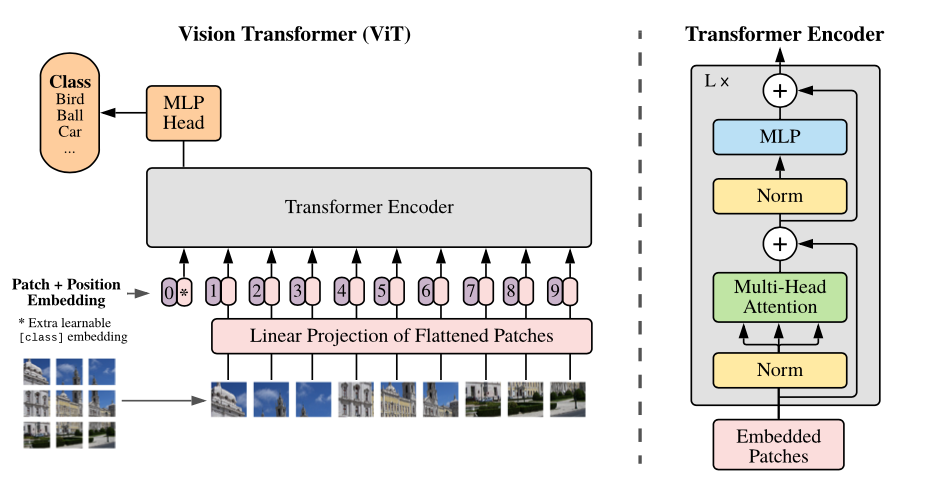

* Paper: https://arxiv.org/abs/2010.11929
* Official repo (in JAX): https://github.com/google-research/vision_transformer


## Loading the data

Load topex-synth data

In [1]:
from datasets import load_dataset
# load a local dataset from image directory (huggingface)
# https://huggingface.co/docs/datasets/image_dataset
DATASET_TRAIN_NAME = '7054-12-300-l_drucker_se_su_st_st_512_32'
DATASET_TRAIN_DIR = f'data/{DATASET_TRAIN_NAME}'

train_ds = load_dataset("imagefolder", data_dir=DATASET_TRAIN_DIR, split="train")
splits = train_ds.train_test_split(test_size=0.1)
train_ds = splits['train']
val_ds = splits['test']

Resolving data files:   0%|          | 0/5088 [00:00<?, ?it/s]

Using custom data configuration default-0505dd7e3047a2ad
Found cached dataset imagefolder (/home/dennis/.cache/huggingface/datasets/imagefolder/default-0505dd7e3047a2ad/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


Load topex-real data (only classes contained in train set)

In [2]:
DATASET_TEST_NAME = 'topex-real-123_pb_256'
DATASET_TEST_DIR = f'data/{DATASET_TEST_NAME}'

test_ds = load_dataset("imagefolder", data_dir=DATASET_TEST_DIR, split="test")
# We use train_test_split function to get val and test sets
# splits = test_ds.train_test_split(test_size=0.9, stratify_by_column='label')
# val_ds = splits['train']
# test_ds = splits['test']




Resolving data files:   0%|          | 0/6146 [00:00<?, ?it/s]

Using custom data configuration default-26068d303f0972f6
Found cached dataset imagefolder (/home/dennis/.cache/huggingface/datasets/imagefolder/default-26068d303f0972f6/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


Map id2label and label2id

In [3]:
id2label = {id:label for id, label in enumerate(train_ds.features['label'].names)}
label2id = {label:id for id,label in id2label.items()}
display(id2label)

{0: '03011-205',
 1: '03026-206',
 2: '03059-08',
 3: '03288-05x20',
 4: '1015_du',
 5: '3054-12.02.17.4',
 6: '3054-12.06.07.3',
 7: '3054-12.06.08.3',
 8: '3054-12.06.14.4',
 9: '3054-12.06.19.4',
 10: '3054-12.06.30.3',
 11: '3054-12.07.16.4',
 12: '3054-12.11.01.4',
 13: '3054-12.21.01.4',
 14: '3054-12.22.03.3',
 15: '3054-12.22.04.3',
 16: '3054-12.25.03.3',
 17: '3054-12.25.04.3',
 18: '3054-12.25.06.4',
 19: '3054-12.27.03.3',
 20: '3054-12.27.05.3',
 21: '3054-12.33.01.4',
 22: '3054-12.33.08.4',
 23: '3108-12.01.05.3',
 24: '3108-12.01.15.4',
 25: '3108-12.04.03.4',
 26: '3108-12.06.04.4',
 27: '3108-12.06.06.4',
 28: '3108-12.06.12.4',
 29: '3108-12.06.18.4',
 30: '3108-12.08.10.4',
 31: '3108-12.09.03.4',
 32: '3108-12.13.11.4',
 33: '3108-12.13.14.4',
 34: '3108-12.29.01.3',
 35: '3108-12.33.01.4',
 36: '3108-12.33.04.3',
 37: '3108-12.35.00.4',
 38: '414768_30',
 39: '418mm_d4_-_montiert_v1',
 40: '6000-2rsr',
 41: '6002-2rs1',
 42: '6003-2rs1',
 43: '610_404_00',
 44: '6

Dataset({
    features: ['image', 'label'],
    num_rows: 4579
})

#labels: 159


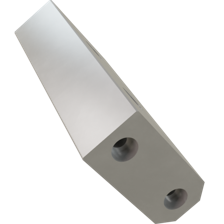

label id: 59
label name: 7054-12.82.01


In [4]:
# Dataset summary
display(train_ds)
# Detailed Features
# display(train_ds.features)
# Numer of labels
print(f'#labels: {len(train_ds.features["label"].names)}')
# Example Image
display(train_ds[0]['image'].resize((224,224)))
# Example Label
print(f'label id: {train_ds[0]["label"]}')
print(f'label name: {id2label[train_ds[0]["label"]]}')

Display some val dataset information

Dataset({
    features: ['image', 'label'],
    num_rows: 509
})

#labels: 159


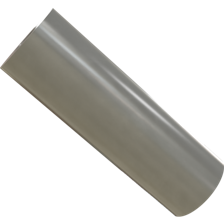

label id: 19
label name: 3054-12.27.03.3


In [5]:
# Dataset summary
display(val_ds)
# Detailed Features
# display(test_ds.features)
# Numer of labels
print(f'#labels: {len(val_ds.features["label"].names)}')
# Example Image
display(val_ds[0]['image'].resize((224,224)))
# Example Label
print(f'label id: {val_ds[0]["label"]}')
print(f'label name: {id2label[val_ds[0]["label"]]}')

Display some test dataset information

Dataset({
    features: ['image', 'label'],
    num_rows: 6146
})

#labels: 102


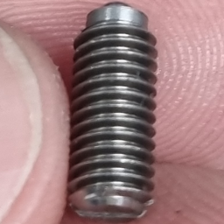

label id: 0
label name: 03011-205


In [6]:
# Dataset summary
display(test_ds)
# Detailed Features
# display(test_ds.features)
# Numer of labels
print(f'#labels: {len(test_ds.features["label"].names)}')

# Example Image
display(test_ds[0]['image'].resize((224,224)))
# Example Label
print(f'label id: {test_ds[0]["label"]}')
print(f'label name: {id2label[test_ds[0]["label"]]}')

## Preprocessing the data

We will now preprocess the data. The model requires 2 things: `pixel_values` and `labels`. 

We will perform data augmentaton **on-the-fly** using HuggingFace Datasets' `set_transform` method (docs can be found [here](https://huggingface.co/docs/datasets/package_reference/main_classes.html?highlight=set_transform#datasets.Dataset.set_transform)). The transform is only applied when examples are accessed. This is convenient for tokenizing or padding text, or augmenting images at training time. 

In [7]:
from transformers import ViTFeatureExtractor

feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")

For data augmentation, one can use any available library. Here we'll use torchvision's [transforms module](https://pytorch.org/vision/stable/transforms.html).

In [8]:
from torchvision.transforms import (CenterCrop, 
                                    Compose, 
                                    Normalize, 
                                    RandomHorizontalFlip,
                                    RandomVerticalFlip,
                                    Resize, 
                                    ToTensor)

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
_train_transforms = Compose(
        [   
            Resize(feature_extractor.size),
            RandomHorizontalFlip(),
            RandomVerticalFlip(),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize(feature_extractor.size),
            CenterCrop(feature_extractor.size),
            ToTensor(),
            normalize,
        ]
    )

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

Apply the transforms to our images

In [9]:
# Set the transforms
train_ds.set_transform(train_transforms)
val_ds.set_transform(val_transforms)
test_ds.set_transform(val_transforms)

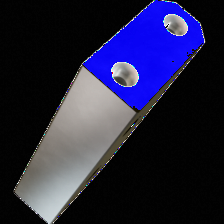

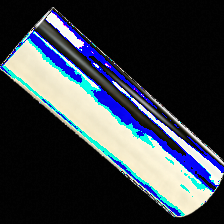

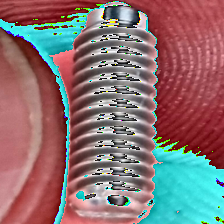

In [10]:
from PIL import Image
import torchvision.transforms as transforms
sample = transforms.ToPILImage()(train_ds[0]["pixel_values"])
display(sample)
sample = transforms.ToPILImage()(val_ds[0]["pixel_values"])
display(sample)
sample = transforms.ToPILImage()(test_ds[0]["pixel_values"])
display(sample)


In [11]:
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}


## Define the model

Here we define the model. We define a `ViTForImageClassification`, which places a linear layer ([nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)) on top of a pre-trained `ViTModel`. The linear layer is placed on top of the last hidden state of the [CLS] token, which serves as a good representation of an entire image. 

The model itself is pre-trained on ImageNet-21k, a dataset of 14 million labeled images. Info [here](https://huggingface.co/google/vit-base-patch16-224-in21k).

We also specify the number of output neurons. We set the id2label and label2id mapping, which we be added as attributes to the configuration of the model (which can be accessed as `model.config`).

In [12]:
from transformers import ViTForImageClassification

num_labels = len(id2label.keys())
def model_init():
    return ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                    num_labels=num_labels,
                                                    id2label=id2label,
                                                    label2id=label2id)
model = model_init()

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


To instantiate a `Trainer`, we will need to define three more things. The most important is the `TrainingArguments`, which is a class that contains all the attributes to customize the training. It requires one folder name, which will be used to save the checkpoints of the model, and all other arguments are optional.

We also set the argument "remove_unused_columns" to False, because otherwise the "img" column would be removed, which is required for the data transformations.

---

## Exploring Hyperparameter Combinations With Sweeps
Weights & Biases Sweeps requires a configuration file to define the hyperparameters to explore, their range of values, and the search strategy, just to name a few. In a notebook these values are stored in a nested dictionary.
In this example, we will explore different combinations of batch_size, learning_rate and weight_decay using a random search. We will evaluate each combination for a single epoch.
The reason we don't explore the number of epochs is because later we will fine-tune a model for 5 epochs using some of the best combinations of values found with Sweeps and the default hyperparameters provided by HuggingFace. In this way, we will be able to assess, to a certain extent, the benefits of running a hyperparameter search for ViT model.


In [20]:
from transformers import TrainingArguments, Trainer
import time

timestamp = time.strftime("%y%m%d%M%S",time.gmtime())

args = TrainingArguments(
    run_name=f"test/synthnet/vit/{DATASET_TRAIN_NAME}-{timestamp}",
    output_dir=f"out/vit/{DATASET_TRAIN_NAME}-{timestamp}",
    seed=42,
    save_strategy="epoch",
    evaluation_strategy="epoch",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    weight_decay=1e-2,
    optim="adamw_torch",
    # adam_beta1=0.9,
    # adam_beta2=0.999,
    # adam_epsilon=1e-8,
    # max_grad_norm=1.0,
    # dataloader_num_workers=0,
    disable_tqdm=False,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    remove_unused_columns=False,
    report_to="wandb"
    # report_to=None
)

2211301556


Here we set the evaluation to be done at the end of each epoch, tweak the learning rate, set the training and evaluation batch_sizes and customize the number of epochs for training, as well as the weight decay.

We also define a `compute_metrics` function that will be used to compute metrics at evaluation. We use "accuracy", which is available in HuggingFace Datasets.


In [28]:
import evaluate
import numpy as np

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

Then we just need to pass all of this along with our datasets to the Trainer:

In [29]:
import torch

trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=feature_extractor,
)

## Train the model

We can now finetune our model by just calling the `train` method:

In [30]:
trainer.train()

***** Running training *****
  Num examples = 4579
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 432
  Number of trainable parameters = 85920927
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


  0%|          | 0/432 [00:00<?, ?it/s]

/home/dennis/miniconda3/envs/py310-notebooks/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
***** Running Evaluation *****
  Num examples = 509
  Batch size = 32


  0%|          | 0/16 [00:00<?, ?it/s]

Saving model checkpoint to out/vit/7054-12-300-l_drucker_se_su_st_st_512_32-1669739026.0715742/checkpoint-144
Configuration saved in out/vit/7054-12-300-l_drucker_se_su_st_st_512_32-1669739026.0715742/checkpoint-144/config.json


{'eval_loss': 4.232124328613281, 'eval_accuracy': 0.550098231827112, 'eval_runtime': 5.4248, 'eval_samples_per_second': 93.828, 'eval_steps_per_second': 2.949, 'epoch': 1.0}


Model weights saved in out/vit/7054-12-300-l_drucker_se_su_st_st_512_32-1669739026.0715742/checkpoint-144/pytorch_model.bin
Feature extractor saved in out/vit/7054-12-300-l_drucker_se_su_st_st_512_32-1669739026.0715742/checkpoint-144/preprocessor_config.json
/home/dennis/miniconda3/envs/py310-notebooks/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


KeyboardInterrupt: 

## Evaluation

Finally, let's evaluate the model on the test set:

In [ ]:
outputs = trainer.predict(test_ds)

***** Running Prediction *****
  Num examples = 5532
  Batch size = 64
/home/dennis/miniconda3/envs/py310-notebooks/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


  0%|          | 0/87 [00:00<?, ?it/s]

In [ ]:
print(outputs.metrics)

{'test_loss': 5.058366298675537, 'test_accuracy': 0.011026753434562546, 'test_runtime': 29.9071, 'test_samples_per_second': 184.973, 'test_steps_per_second': 2.909}


We can also easily create a confusion matrix:

ValueError: The number of FixedLocator locations (157), usually from a call to set_ticks, does not match the number of ticklabels (159).

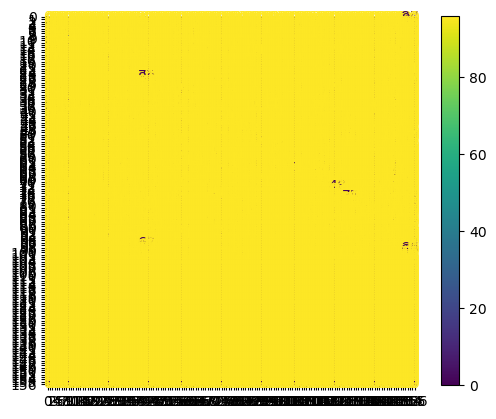

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = train_ds.features['label'].names
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)